# Verifying the Li-Stephens Model inference of the jump rate

This notebook explores a verification of our Li-Stephens Model implementation. Specifically we focus on: (1) estimation of the haplotype copying jump rate when the error rate is given and (2) joint estimation of the jump-rate and the error probability via numerical approximation.

For the joint estimation of the jump-rate and the error probability we are able to obtain the standard errors of each estimate as well by taking the square root of the diagonal of the Hessian matrix. In the case of the marginal jump rate estimation the error probability was fixed at $\epsilon = 10^{-2}$.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import msprime as msp

plt.rcParams['pdf.fonttype'] = 3

import sys
sys.path.append('../../src/')
from plot_utils import *

%matplotlib inline

In [2]:
# Reading in the CSV of results from our various simulations ... 
results_csv = '../../results/ls_verify/ls_simulations_100.csv'
ls_verify_df = pd.read_csv(results_csv)
ls_verify_df.head()

,scales_true,scales_marg_hat,scales_jt_hat,eps_jt_hat,se_scales_jt_hat,se_eps_jt_hat
0,100,102.516313,102.674217,0.019105,24.716874,0.000066
1,200,189.369557,189.650502,0.019182,39.912196,0.000100
2,300,292.669794,293.056054,0.019423,47.277726,0.000085
3,400,417.647663,417.991549,0.019413,40.383416,0.000066
4,500,503.451364,504.012475,0.020576,45.715850,0.000129


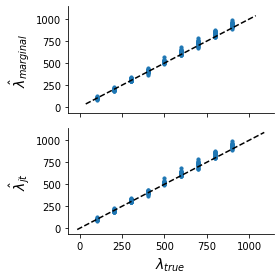

In [3]:
fig, ax = plt.subplots(2,1,figsize=(4,4), sharex=True, sharey=True)
ax[0].scatter(ls_verify_df['scales_true'].values, 
           ls_verify_df['scales_marg_hat'].values, s=10);

ax[1].scatter(ls_verify_df['scales_true'].values, 
           ls_verify_df['scales_jt_hat'].values, s=10);

plot_yx(ax[0], linestyle='--', color='black')
plot_yx(ax[1], linestyle='--', color='black')


ax[1].set_xlabel(r'$\lambda_{true}$', fontsize=14);
ax[1].set_ylabel(r'$\hat{\lambda}_{jt}$', fontsize=14);
ax[0].set_ylabel(r'$\hat{\lambda}_{marginal}$', fontsize=14);

debox(ax[0]); debox(ax[1]);
fig.tight_layout();

Text(0.5, 0, '$\\hat{\\lambda}_{marginal}$')

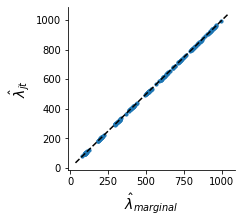

In [4]:
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.scatter(ls_verify_df['scales_marg_hat'], 
           ls_verify_df['scales_jt_hat'], s=10)

debox(ax); 
plot_yx(ax, color='black', linestyle='--');
ax.set_ylabel(r'$\hat{\lambda}_{jt}$', fontsize=14);
ax.set_xlabel(r'$\hat{\lambda}_{marginal}$', fontsize=14);

Text(0, 0.5, '$\\hat{\\epsilon}_{jt}$')

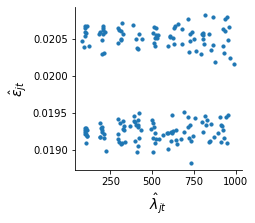

In [5]:
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.scatter(ls_verify_df['scales_jt_hat'], 
           ls_verify_df['eps_jt_hat'], s=10)

debox(ax); 
# plot_yx(ax, color='black', linestyle='--');
ax.set_xlabel(r'$\hat{\lambda}_{jt}$', fontsize=14);
ax.set_ylabel(r'$\hat{\epsilon}_{jt}$', fontsize=14);

## Plotting the Joint Likelihood Surface

13840


20it [02:29,  7.50s/it]


CPU times: user 58.5 s, sys: 148 ms, total: 58.6 s
Wall time: 58.8 s
CPU times: user 33.8 s, sys: 112 ms, total: 34 s
Wall time: 34.1 s
CPU times: user 1min 9s, sys: 489 ms, total: 1min 9s
Wall time: 1min 13s


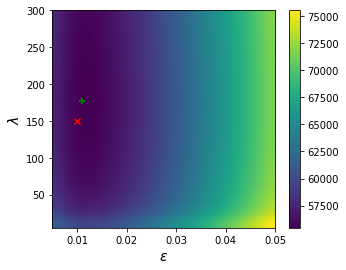

In [6]:
from li_stephens import LiStephensHMM
from tqdm import tqdm

mut_rate = 1e-8
rec_rate = 2e-8
length = 10e6
seed = 24

n = 50
ts = msp.simulate(Ne=1e4, sample_size=n, 
                  mutation_rate=mut_rate, 
                  recombination_rate=rec_rate, length=length, random_seed=seed)

# Generating the haplotype reference panel...
geno = ts.genotype_matrix().T
phys_pos = np.array([v.position for v in ts.variants()])
rec_pos = phys_pos * rec_rate

ac = np.sum(geno, axis=0)
mac = np.minimum(ac, n - ac)
maf = mac / n
idx = np.where(maf > 0.02)[0]
print(idx.size)

ls_model = LiStephensHMM(haps=geno[:,idx], positions=rec_pos[idx])
test_hap,_ = ls_model._sim_haplotype(scale=1.5e2, eps=1e-2, seed=42)

x = 20
M = np.zeros(shape=(x,x))

scales=np.linspace(5, 300, x)
eps = np.linspace(5e-3, 5e-2, x)
for i,s in tqdm(enumerate(scales)):
    for j,e in enumerate(eps):
        M[i,j]=ls_model._negative_logll(test_hap, scale=s, eps=e)
        
bounds = [(10., 1e4), (1e-3, 0.2)]
start_scale = np.random.uniform(low=10, high=1e4, size=3)
start_eps = np.random.uniform(low=1e-3, high=0.2, size=3)

%time res1 = ls_model._infer_params(test_hap, x0=[start_scale[0], start_eps[0]], bounds=bounds)
%time res2 = ls_model._infer_params(test_hap, x0=[start_scale[1], start_eps[1]], bounds=bounds)
%time res3 = ls_model._infer_params(test_hap, x0=[start_scale[2], start_eps[2]], bounds=bounds)

fig, ax = plt.subplots(1,1,figsize=(5,4))
im = ax.imshow(M, extent=[5e-3, 5e-2, 5, 300], interpolation='Gaussian', origin='lower', aspect='auto')
ax.scatter(1e-2, 1.5e2, marker='x', color='red')
ax.scatter(res1.x[1], res1.x[0], marker='+', color='green')
ax.scatter(res2.x[1], res2.x[0], marker='+', color='green')
ax.scatter(res3.x[1], res3.x[0], marker='+', color='green')

# ax.axvline(x=1e-2, color='red')
ax.set_ylabel(r'$\lambda$', fontsize=14)
ax.set_xlabel(r'$\epsilon$', fontsize=14)
fig.colorbar(im)